In [1]:
%pylab inline

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import lconv
import tensorflow as tf

# to stop TF from using all GPU RAM
sess = tf.compat.v1.InteractiveSession()

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense

In [3]:
EPOCHS = 30

from scipy import ndimage

def rotated_ims_rand(x):
    return np.float32([ndimage.rotate(i, (np.random.rand()-.5)*180, reshape=False, mode='nearest') for i in x])
        
class Scramble_x:
    def __init__(self,x):
        s = x.shape[1:-1]
        self.idx = np.argsort(np.random.rand(np.prod(s)))
        r,c = np.int0(self.idx/s[0]), (self.idx % s[1]) 
        self.x = np.float32([i[r,c].reshape(s+(x.shape[-1],)) for i in x])



In [4]:
dataset_name ='mnist' # 'cifar10' # 'mnist' #

dataset = eval("tf.keras.datasets.%s.load_data()" %dataset_name) 
(x_train, y_train), (x_test,y_test) = dataset
if len(x_train.shape) == 3:
    # mnist channel is missing
    x_train = x_train[...,np.newaxis]
    
# normalize
x_train = x_train/x_train[:100].max() -.5 
# make categorical
y_train = tf.keras.utils.to_categorical(y_train)



#'Rotating images'
# x_train = rotated_ims_rand(x_train)
    
#'Scrambling images'
# scr = Scramble_x(x_train)
# x_train = scr.x
# scr.idx # contains the permutation; can be used to unscramble


# Basic Usage

In [5]:
inp = Input(x_train[0].shape)

# flatten the image coordinates 
x = tf.reshape(inp, shape=(-1,np.prod(inp.shape[1:-1]), inp.shape[-1]))

L_conv_layer = lconv.L_Conv(num_filters= 32,  
                      kernel_size= 9, # number of L_i  
                      L_hid = [12], # hidden layers used in encoding L_i ([]: L_i will be full matrices)
                      activation = 'relu',)

x = L_conv_layer(x)
    
x = Flatten()(x)

out = Dense(y_train.shape[-1], activation='softmax')(x)

model = Model(inputs = [inp], outputs = [out])
model.compile(loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 784, 1)]          0         
_________________________________________________________________
l__conv (L_Conv)             (None, 784, 32)           151104    
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                250890    
Total params: 401,994
Trainable params: 401,994
Non-trainable params: 0
_________________________________________________________________


In [6]:
h = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2856 - accuracy: 0.9144 - val_loss: 0.1349 - val_accuracy: 0.9596
Epoch 2/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1237 - accuracy: 0.9645 - val_loss: 0.1103 - val_accuracy: 0.9700
Epoch 3/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0941 - accuracy: 0.9734 - val_loss: 0.1022 - val_accuracy: 0.9727
Epoch 4/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0756 - accuracy: 0.9787 - val_loss: 0.1123 - val_accuracy: 0.9735
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0650 - accuracy: 0.9818 - val_loss: 0.1119 - val_accuracy: 0.9737
Epoch 6/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0553 - accuracy: 0.9839 - val_loss: 0.1015 - val_accuracy: 0.9726
Epoch 7/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0467 - accuracy: 0.9871 - val_loss: 0.1069 - val_accuracy:

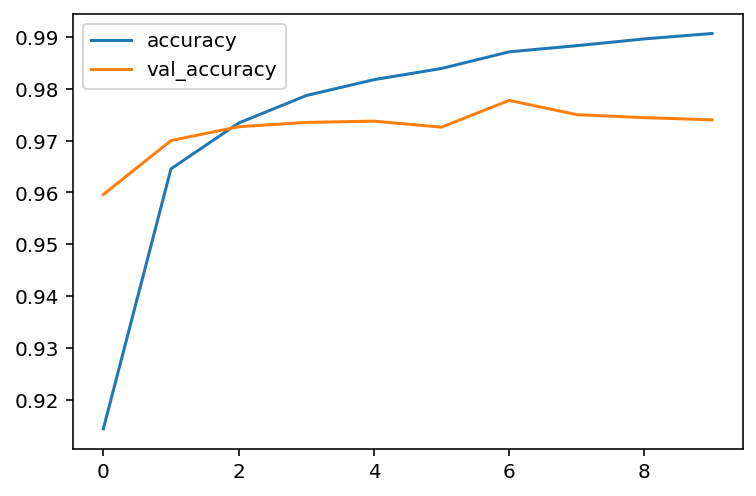

In [7]:
for k in ['accuracy','val_accuracy']:
    plot(h.history[k], label = k)
    
legend()

# parameters of the L-conv layer

In [8]:
# encoder, decoder of L_i
[w.shape for w in L_conv_layer.L.weights]

[TensorShape([8, 12, 784]), TensorShape([8, 784, 12])]

In [9]:
# weights W^i
L_conv_layer.w.shape

TensorShape([9, 1, 32])

In [10]:
L1, L2 = L_conv_layer.L.weights

In [11]:
Ls = (L2 @ L1) # N_L x d x d
Ls.shape

TensorShape([8, 784, 784])

In [16]:
C0 = tf.matmul(Ls, Ls, transpose_a=True) 
C0.shape

TensorShape([8, 784, 784])

In [17]:
C = tf.reduce_sum(C0, axis = 0) / L1.shape[0]
C.shape

TensorShape([784, 784])

In [62]:
L1.shape

TensorShape([8, 12, 784])

In [18]:
cn = C.numpy()
cn.shape

(784, 784)

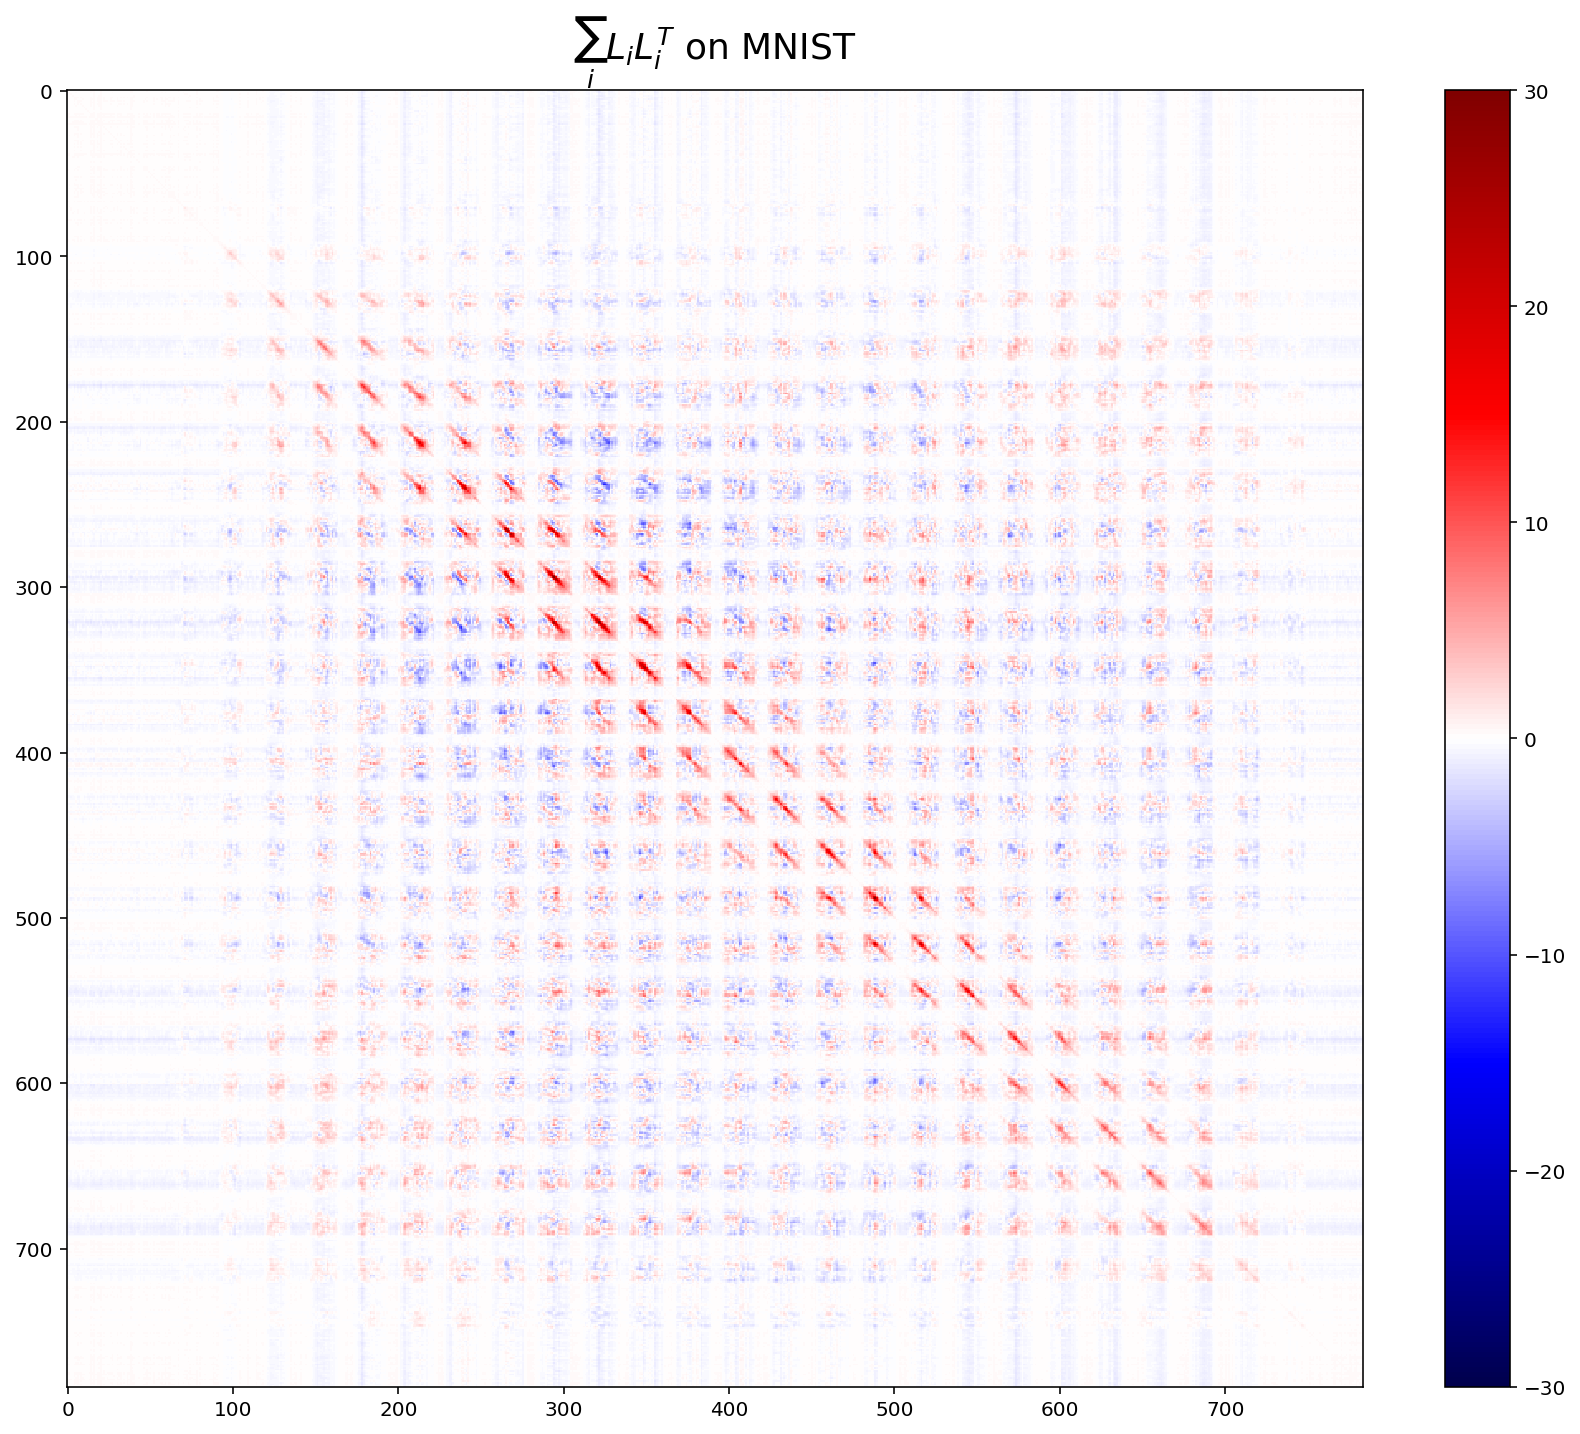

In [64]:
figure(figsize=(12,10))
a = 30
imshow((cn[::1,::1]), cmap = 'seismic', vmin=-a, vmax=a)
colorbar()
title(r'$\sum_iL_iL_i^T$ on %s' %dataset_name.upper() , size = 18)
tight_layout()
savefig('./figs/LL-%s.pdf'%dataset_name)
savefig('./figs/LL-%s.png'%dataset_name, dpi = 150)

In [23]:
len(Ls)

8

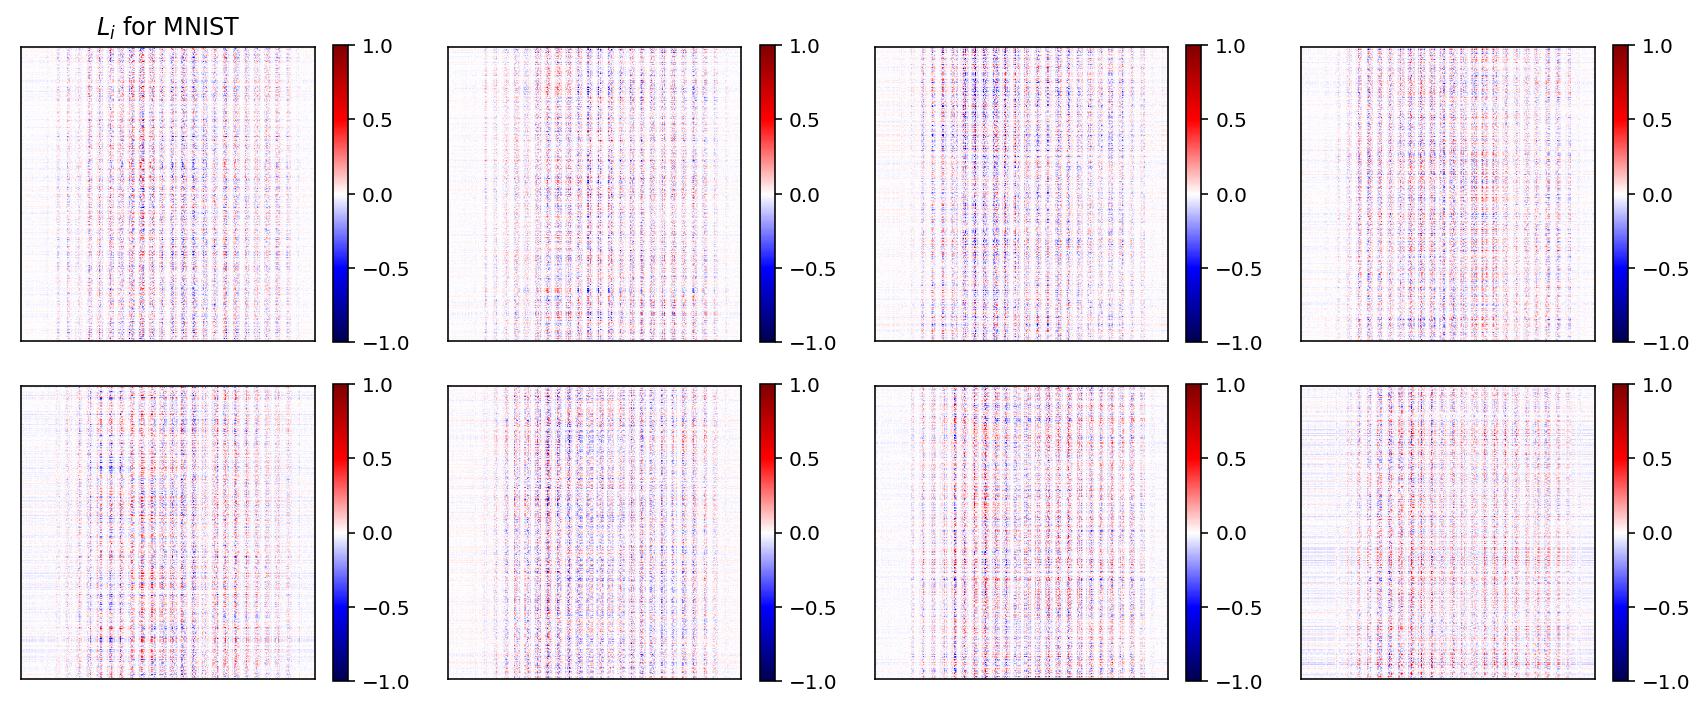

In [59]:
figure(figsize=(12,5))
ii = 0
for l in Ls:
    ii+=1
    subplot(2,4,ii)
    if ii==1:
        title(r'$L_i$ for %s' %(dataset_name.upper()) )
    imshow(l.numpy(), cmap = 'seismic', vmin=-1, vmax=1)
    colorbar()
    xticks([])
    yticks([])
    
tight_layout()

savefig('./figs/L_i_%s.pdf' %dataset_name)
savefig('./figs/L_i_%s.png' %dataset_name, dpi=150)

In [25]:
ei_cn = eigh(cn)

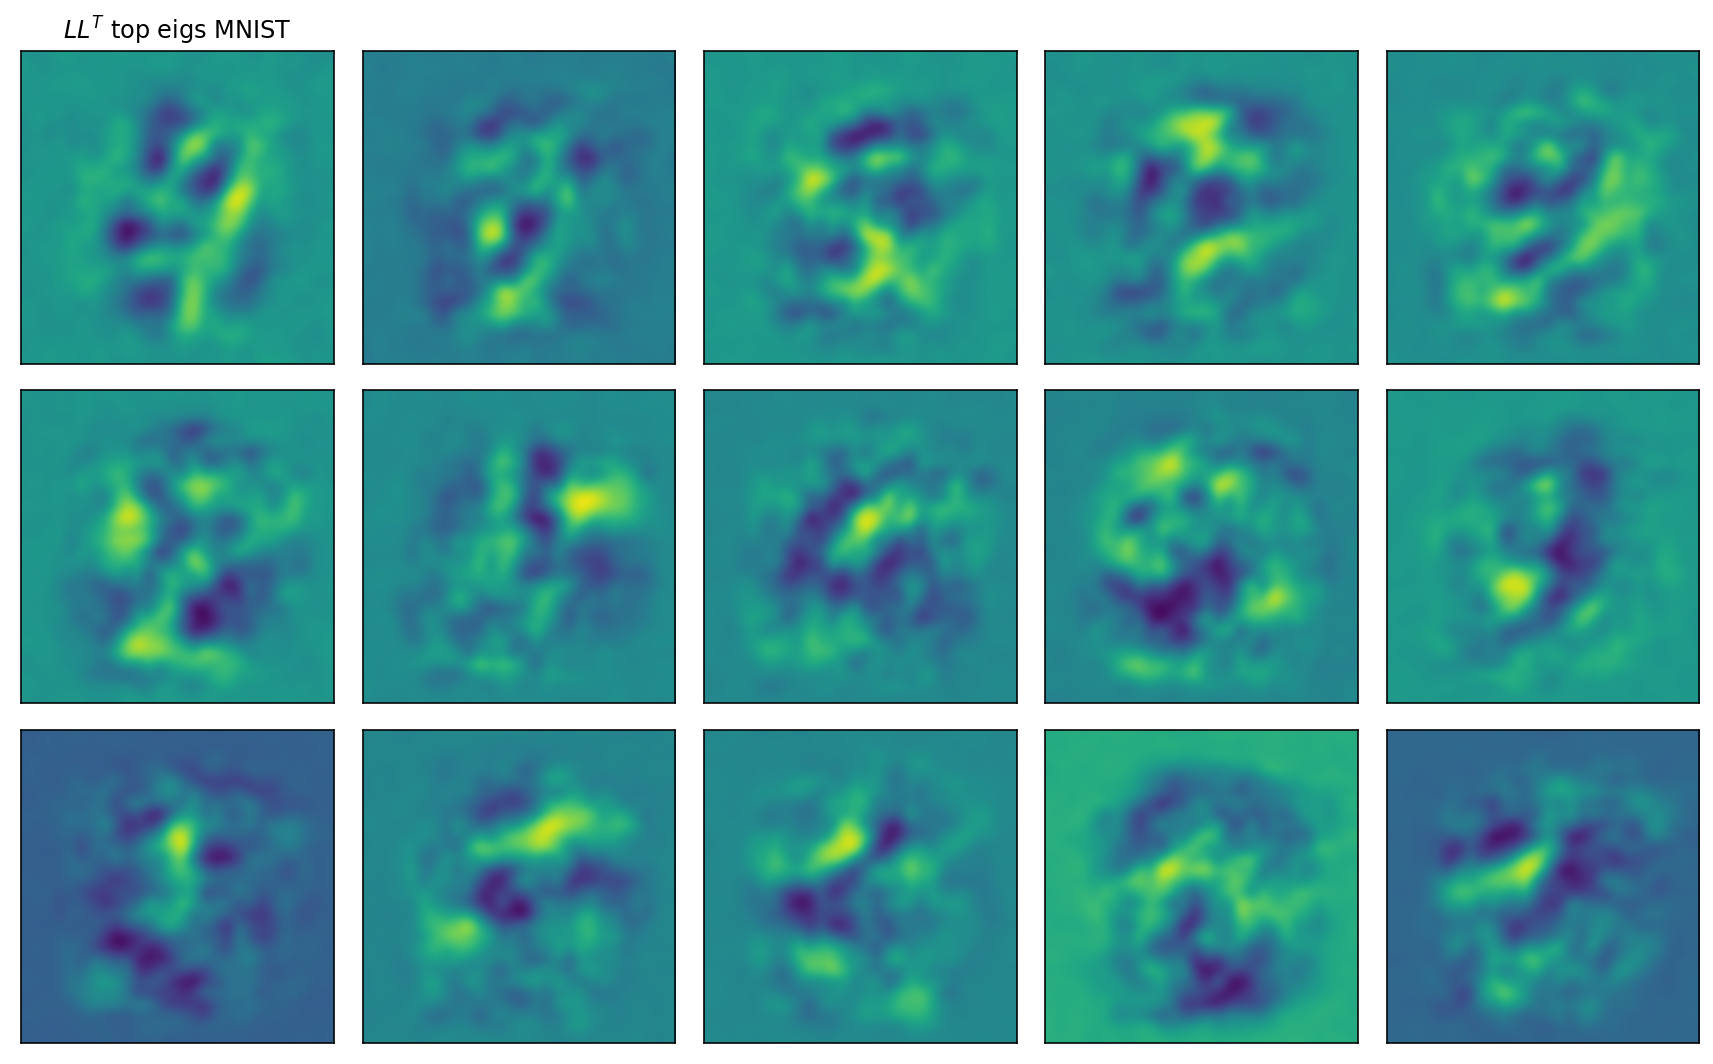

In [45]:
j = 3
figure(figsize=(12,j*2.5))
ii=0
m = 5
a = .25
for i in ei_cn[1].T[-j*m-1:-1]:
    ii+=1
    subplot(j,m,ii)
    if ii==1:
        title('$LL^T$ top eigs %s'%dataset_name.upper())
    imshow(i.reshape(x_train.shape[1:-1]), interpolation='bicubic', )
#           cmap = 'seismic', vmin=-a, vmax=a)
#     colorbar()
    xticks([])
    yticks([])
tight_layout()

savefig('./figs/LL-eigs-%s.pdf'%dataset_name)
savefig('./figs/LL-eigs-%s.png'%dataset_name, dpi = 150)

$LL^T$ seems different from $H$. Even the tp eigenvectors do not match very much 

# Relation with Covariance eigs

In [52]:
n = 1000
a = x_train[:n].reshape((n,-1))
a+= 1e-4*rand(*a.shape) #+0.5

In [53]:
corrcoef(a.T).shape

(784, 784)

In [54]:
a.min()

-0.4999999999998695

In [55]:
# H = corrcoef(a.T) #
H = mean(a[...,newaxis] @ a[:,newaxis], 0)

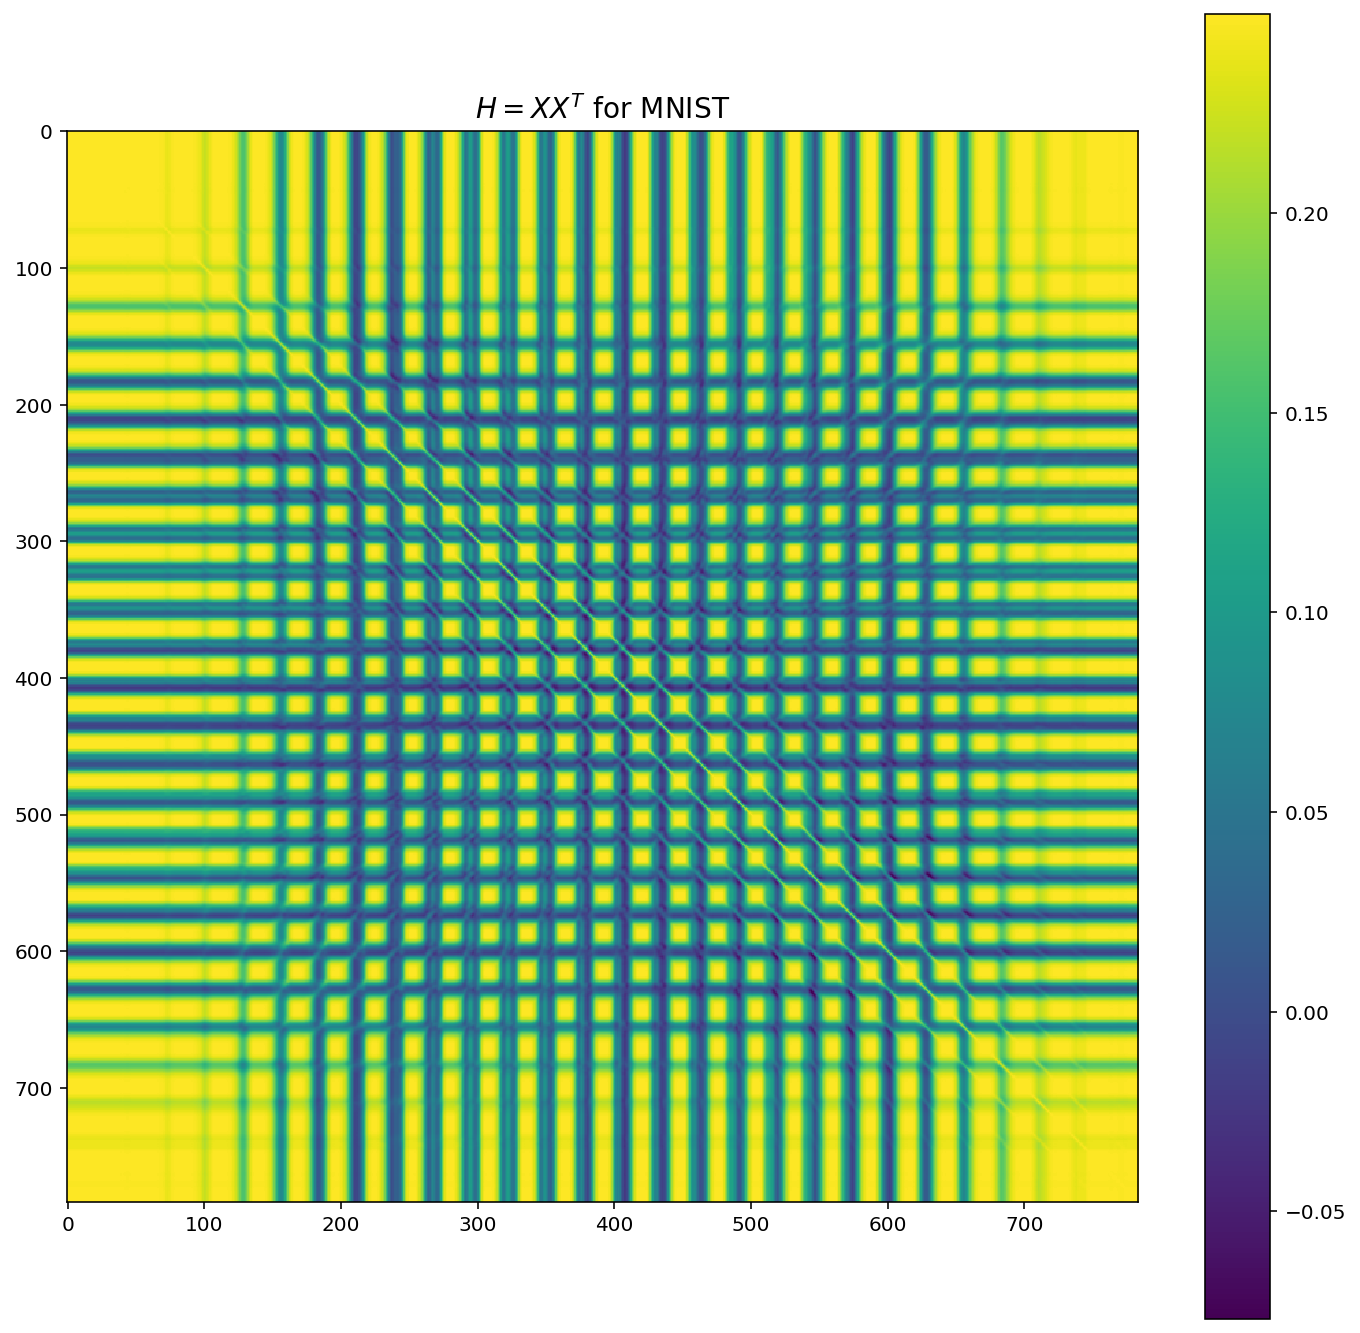

In [56]:
figure(figsize=(12,12))

title(r'$H = XX^T$ for MNIST', size = 14)
imshow(H[::1,::1])
colorbar()

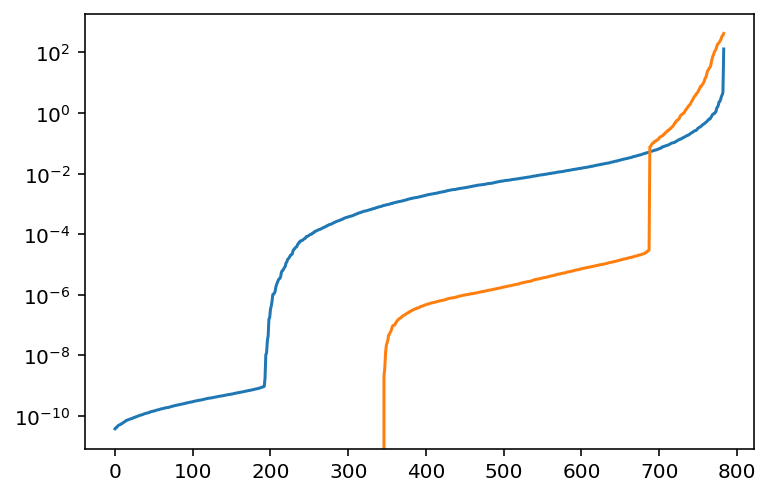

In [77]:
ei_H = eigh(H)
plot(ei_H[0], label = 'H eigs')
plot(ei_cn[0], label = r'$LL^T$ eigs')
yscale('log')

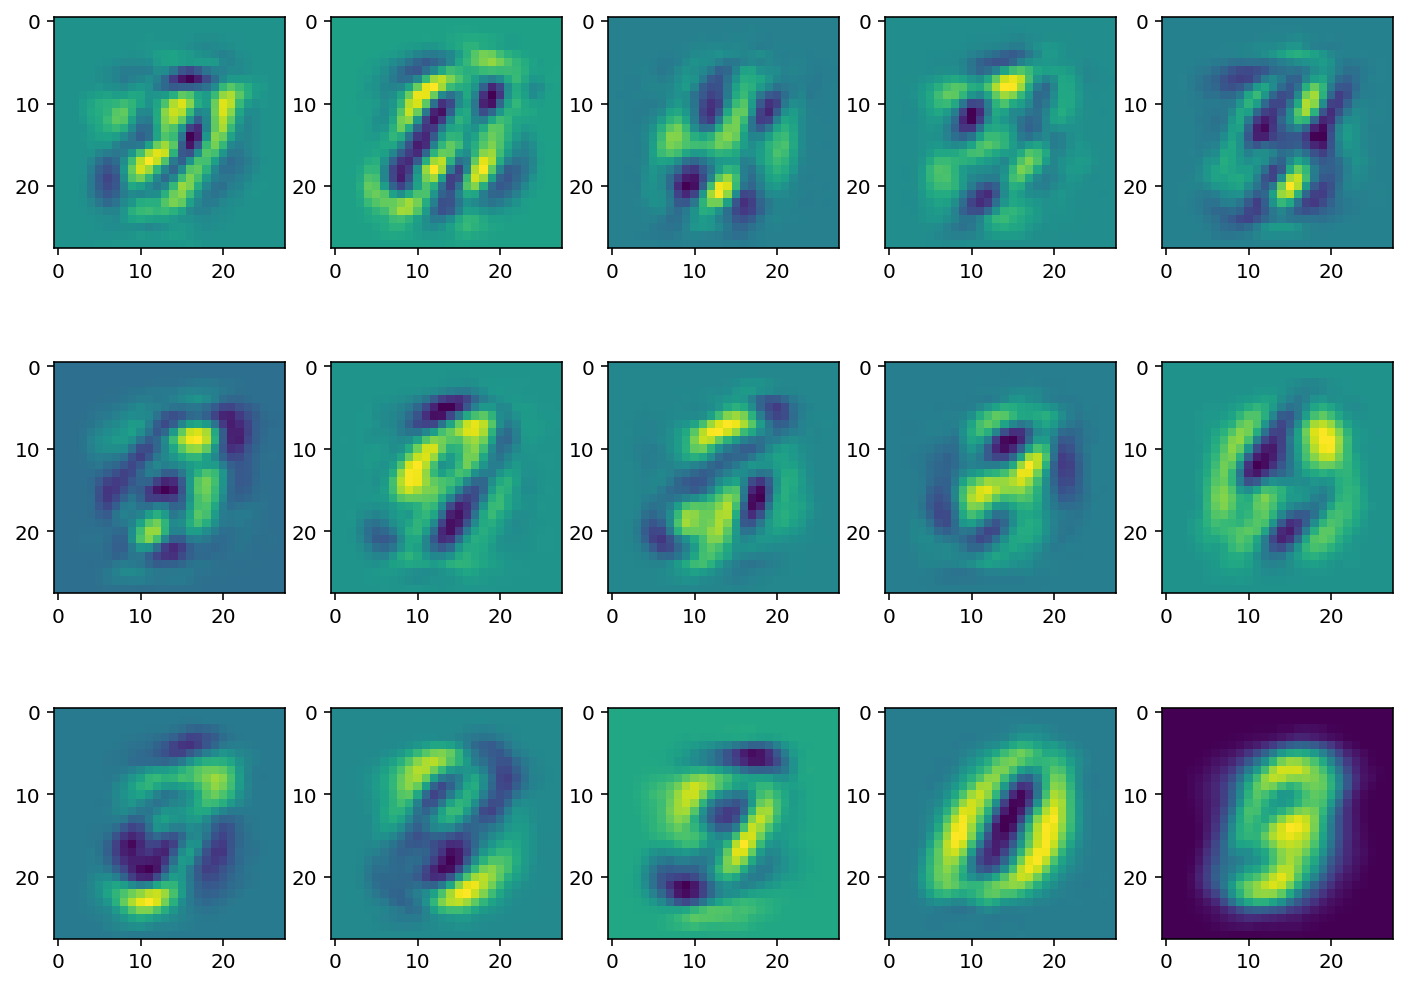

In [78]:
j = 3
figure(figsize=(12,j*3))
ii=0
m = 5
for i in ei_H[1].T[-j*m:]:
    ii+=1
    subplot(j,m,ii)
    imshow(i.reshape((28,28)))

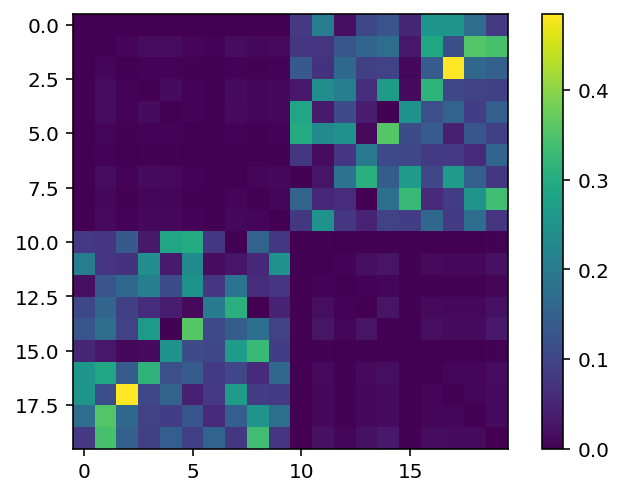

In [79]:
n_eigs = 10
imshow(abs(corrcoef(ei_cn[1].T[-n_eigs:], ei_H[1].T[-n_eigs-1:-1])-eye(2*n_eigs)))
colorbar()